In [1]:
try:
    installation_done
except:
    !pip install -q e2cnn
    installation_done = True

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


**Common Test I. Multi-Class Classification**

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset Description:** The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 


In [2]:
import copy
import warnings

import e2cnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from e2cnn import gspaces, nn as e2nn
from itertools import cycle
from PIL import Image
from skimage import io, transform
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.datasets import DatasetFolder

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Data Preparation

In [3]:
N = 4
lr = 0.001
epochs = 40
batch_size = 64
dataset_folder = '/kaggle/input/ml4sci-2023/dataset'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(128),
    transforms.Resize(256),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.RandomCrop(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [5]:
def npy_loader(path):
    sample = np.load(path, allow_pickle=True)[0]
    sample = 255 * (sample / sample.max())
    sample = Image.fromarray(sample.astype('uint8')).convert("RGB")
    return sample
    

trainset = DatasetFolder(
    root=dataset_folder+'/train',
    loader=npy_loader,
    extensions=['.npy'],
    transform = train_transforms
)

testset = DatasetFolder(
    root=dataset_folder+'/val',
    loader=npy_loader,
    extensions=['.npy'],
    transform = test_transforms
)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True)

# Visualization

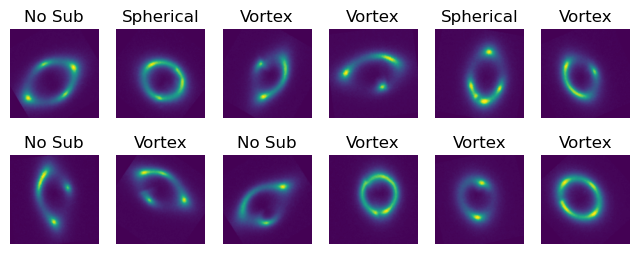

In [6]:
labels = {0: 'No Sub',1:'Spherical', 2:'Vortex'}
figure = plt.figure(figsize=(8, 3))
cols, rows = 6, 2
idx = np.random.randint(0, len(trainset), cols*rows)
for i in range(1, cols * rows + 1):
    img, label = trainset[idx[i-1]]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

# Model

In [7]:
class C8SteerableCNN(torch.nn.Module):
    def __init__(self, n_classes=3):   
        super(C8SteerableCNN, self).__init__()
        self.r2_act = gspaces.Rot2dOnR2(N=N)
        in_type = e2nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        self.input_type = in_type
        out_type = e2nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = e2nn.SequentialModule(
            e2nn.MaskModule(in_type, 128, margin=1),
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        in_type = self.block1.out_type
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        in_type = self.block2.out_type
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        in_type = self.block3.out_type
        out_type = e2nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        in_type = self.block4.out_type
        out_type = e2nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        in_type = self.block5.out_type
        out_type = e2nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = e2nn.GroupPooling(out_type)
        c = self.gpool.out_type.size
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(40000, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        x = e2nn.GeometricTensor(input, self.input_type)
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)   
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.pool3(x)
        x = self.gpool(x)
        x = x.tensor
        x = self.fully_net(x.reshape(x.shape[0], -1))
        return x

In [8]:
model = C8SteerableCNN().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training

In [9]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(epochs):
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    total = 0
    correct = 0
    tqdm_bar = tqdm(train_loader, desc=f'loss: inf')
    for i, (x, t) in enumerate(tqdm_bar):        
        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)
        y_pred = y.flatten().to(torch.float64)
        
        _, prediction = torch.max(y.data, 1)
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        loss = loss_function(y, t)
        tr_loss_epoch.append(loss.item())
        loss.backward()

        optimizer.step()
        if i%100 == 0:
            tqdm_bar.set_description(f'loss: {str(loss.item())[:4]}')
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct/total*100)
    
    
    if epoch % 5 == 0:
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()
            for i, (x, t) in enumerate(tqdm(test_loader)):
                x = x.to(device)
                t = t.to(device)
                y = model(x)
                
                loss = loss_function(y, t)
                test_loss_epoch.append(loss.item())

                _, prediction = torch.max(y.data, 1)
                total += t.shape[0]
                correct += (prediction == t).sum().item()
                
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct/total*100)
        print("epoch {} | test accuracy: {}".format(epoch,correct/total*100))
        
        test_accuracy = correct/total*100
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = copy.deepcopy(model)    

torch.save(best_model.state_dict(), 'bestmodel.pth')
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████| 118/118 [01:04<00:00,  1.82it/s]


epoch 0 | test accuracy: 34.13333333333333


100%|██████████| 118/118 [00:44<00:00,  2.66it/s]


epoch 5 | test accuracy: 93.81333333333333


100%|██████████| 118/118 [00:48<00:00,  2.42it/s]


epoch 10 | test accuracy: 95.29333333333334


100%|██████████| 118/118 [00:44<00:00,  2.67it/s]


epoch 15 | test accuracy: 94.92


100%|██████████| 118/118 [00:44<00:00,  2.64it/s]


epoch 20 | test accuracy: 95.10666666666665


100%|██████████| 118/118 [00:44<00:00,  2.63it/s]


epoch 25 | test accuracy: 95.01333333333334


100%|██████████| 118/118 [00:39<00:00,  2.96it/s]


epoch 30 | test accuracy: 95.22666666666667


100%|██████████| 118/118 [00:40<00:00,  2.93it/s]


epoch 35 | test accuracy: 95.02666666666667


loss: 0.27: 100%|██████████| 469/469 [05:54<00:00,  1.32it/s]


# Loading Best Model

In [10]:
model = C8SteerableCNN().to(device)
model.load_state_dict(torch.load('bestmodel.pth'))

<All keys matched successfully>

# Plotting Loss

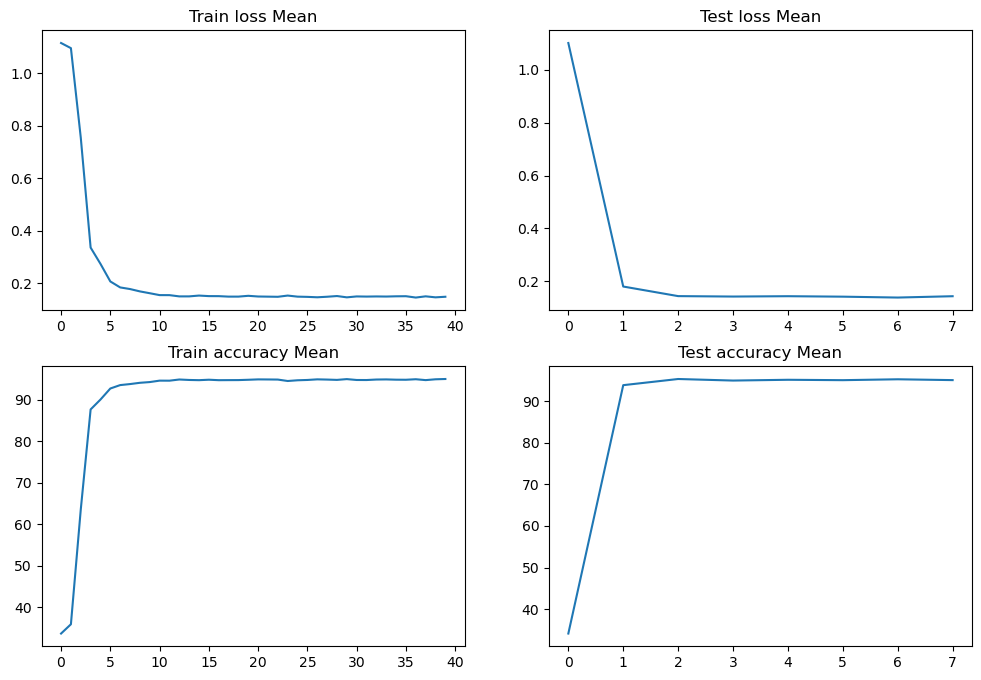

In [11]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 2
figure.add_subplot(rows, cols, 1)
plt.title('Train loss Mean')
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title('Test loss Mean')
plt.plot(all_test_loss_mean)
figure.add_subplot(rows, cols, 3)
plt.title('Train accuracy Mean')
plt.plot(all_train_accuracy)
figure.add_subplot(rows, cols, 4)
plt.title('Test accuracy Mean')
plt.plot(all_test_accuracy)

# Testing

In [12]:
true_label, pred_label, pred_score, one_hot = [], [], [], []
with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        _y = model(x)

        loss = loss_function(_y, y)

        _, pred = torch.max(_y.data, 1)
        true_label += y.tolist()
        pred_label += pred.tolist()
        pred_score += _y.tolist()
        one_hot += np.eye(3)[y.cpu().numpy()].tolist()

100%|██████████| 118/118 [00:39<00:00,  2.97it/s]


# Confusion Matrix

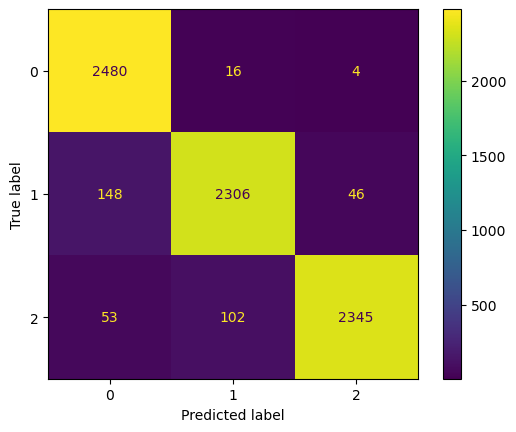

In [13]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(true_label, pred_label)
).plot()

# AUC Score

In [14]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [15]:
roc_auc_score(np.array(true_label),[softmax(i) for i in np.array(pred_score)], multi_class='ovr')

0.9928092533333333

# ROC-CURVE

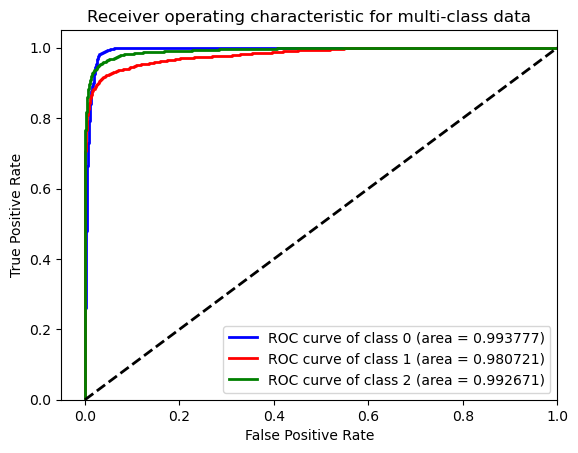

In [16]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(one_hot)[:, i], np.array(pred_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()